# **Stock Prediction using LSTM** (Long Short-Term Memory)

Import stock data directly from Yahoo finance

## IMPORT FILES

In [1]:
# yahoo finance
import yfinance as yf
from enum import auto

# for data manipulation
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

# for evaluation, we will use these libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# for model building we will use these libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

# for plotting
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


## TCS

In [2]:
hist = yf.Ticker('TCS.NS')
data = hist.history(period='max', auto_adjust=True, rounding=True)  # rounding is for getting the price value upto 2 decimal places
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-08-12 00:00:00+05:30,27.51,28.41,27.51,28.20,212976,0.0,0.0
2002-08-13 00:00:00+05:30,28.24,28.69,27.62,27.82,153576,0.0,0.0
2002-08-14 00:00:00+05:30,27.88,27.88,25.38,25.90,822776,0.0,0.0
2002-08-15 00:00:00+05:30,25.90,25.90,25.90,25.90,0,0.0,0.0
2002-08-16 00:00:00+05:30,25.77,26.99,25.40,25.84,811856,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-04 00:00:00+05:30,3486.30,3548.00,3477.30,3537.75,1788138,0.0,0.0
2023-10-05 00:00:00+05:30,3554.00,3624.00,3551.20,3589.35,2990768,0.0,0.0
2023-10-06 00:00:00+05:30,3591.00,3634.95,3575.05,3621.40,2075691,0.0,0.0


Data will be updated autometically

## DATA PROCESSING

select only relevant features

In [3]:
data['Date'] = data.index
data = data[['Date', 'Open', 'High', 'Low', 'Close']]  # choose only relevant features for the model
data.reset_index(drop=True, inplace=True)
data

,Date,Open,High,Low,Close
0,2002-08-12 00:00:00+05:30,27.51,28.41,27.51,28.20
1,2002-08-13 00:00:00+05:30,28.24,28.69,27.62,27.82
2,2002-08-14 00:00:00+05:30,27.88,27.88,25.38,25.90
3,2002-08-15 00:00:00+05:30,25.90,25.90,25.90,25.90
4,2002-08-16 00:00:00+05:30,25.77,26.99,25.40,25.84
...,...,...,...,...,...
5252,2023-10-04 00:00:00+05:30,3486.30,3548.00,3477.30,3537.75
5253,2023-10-05 00:00:00+05:30,3554.00,3624.00,3551.20,3589.35
5254,2023-10-06 00:00:00+05:30,3591.00,3634.95,3575.05,3621.40
5255,2023-10-09 00:00:00+05:30,3645.05,3679.00,3631.00,3638.35


In [4]:
StartDate = data.iloc[0][0]
EndDate = data.iloc[-1][0]  # EndDate = data.iloc[5009][0]
print(StartDate)
print(EndDate)

2002-08-12 00:00:00+05:30
2023-10-10 00:00:00+05:30


In [5]:
data.shape

(5257, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5257 entries, 0 to 5256
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype                       
---  ------  --------------  -----                       
 0   Date    5257 non-null   datetime64[ns, Asia/Kolkata]
 1   Open    5257 non-null   float64                     
 2   High    5257 non-null   float64                     
 3   Low     5257 non-null   float64                     
 4   Close   5257 non-null   float64                     
dtypes: datetime64[ns, Asia/Kolkata](1), float64(4)
memory usage: 205.5 KB


In [7]:
data.isnull().sum()

Date     0
Open     0
High     0
Low      0
Close    0
dtype: int64

In [8]:
data.isnull().values.sum()

0

## VISUALIZATION

In [9]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
y_overall = data.loc[(data['Date'] >= StartDate) & (data['Date'] <= EndDate)]

<ipython-input-9-c3927d914907>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')


In [10]:
monthwise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,1026.476749,1026.049391
February,1035.097816,1033.139417
March,1000.458548,1000.799608
April,993.076443,992.341716
May,1019.653901,1018.921143
June,1043.914143,1043.994053
July,1054.505522,1054.285348
August,1062.443042,1062.946411
September,1072.271278,1071.543877


In [11]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])
fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], y_overall['High'], y_overall['Low']], labels={'Date': 'Date','value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [12]:
closedf = data[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (5257, 2)


In [13]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [14]:
closedf = closedf[closedf['Date'] > '2022-08-19']
close_Stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  282


In [15]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [16]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(282, 1)


In [17]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (169, 1)
test_data:  (113, 1)


In [18]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [19]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (153, 15)
y_train:  (153,)
X_test:  (97, 15)
y_test (97,)


In [20]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (153, 15, 1)
X_test:  (97, 15, 1)


In [21]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [22]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
5/5 [==============================] - 2s 118ms/step - loss: 0.2938 - val_loss: 0.6419
Epoch 2/200
5/5 [==============================] - 0s 19ms/step - loss: 0.2787 - val_loss: 0.6152
Epoch 3/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2648 - val_loss: 0.5906
Epoch 4/200
5/5 [==============================] - 0s 22ms/step - loss: 0.2526 - val_loss: 0.5679
Epoch 5/200
5/5 [==============================] - 0s 19ms/step - loss: 0.2412 - val_loss: 0.5471
Epoch 6/200
5/5 [==============================] - 0s 20ms/step - loss: 0.2306 - val_loss: 0.5279
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 0.2212 - val_loss: 0.5100
Epoch 8/200
5/5 [==============================] - 0s 23ms/step - loss: 0.2120 - val_loss: 0.4933
Epoch 9/200
5/5 [==============================] - 0s 21ms/step - loss: 0.2036 - val_loss: 0.4774
Epoch 10/200
5/5 [==============================] - 0s 19ms/step - loss: 0.1957 - val_loss: 0.4623
Epoch 11/200
5/5 [

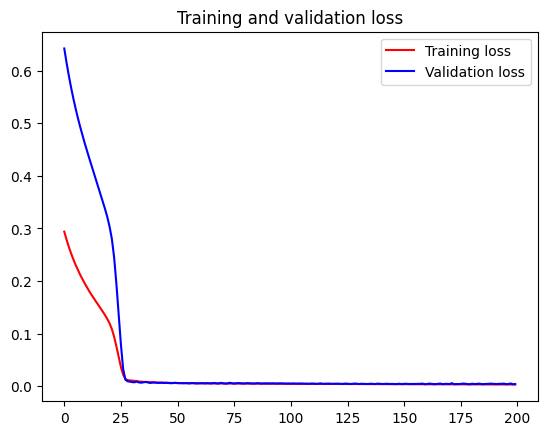

<Figure size 640x480 with 0 Axes>

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [24]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

4/4 [==============================] - 0s 3ms/step


((153, 1), (97, 1))

In [25]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [26]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  42.936966422593116
Train data MSE:  1843.5830855748884
Train data MAE:  33.805408752042496
-------------------------------------------------------------------------------------
Test data RMSE:  47.887383102720044
Test data MSE:  2293.201460426677
Test data MAE:  34.46542858005797


In [27]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.9199668427810699
Test data explained variance regression score: 0.8770507400528541


In [28]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.9199579973724084
Test data R2 score: 0.8617535631082651


In [29]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.00018201830365357198
Test data MGD:  0.00019929416735596636
----------------------------------------------------------------------
Train data MPD:  0.5787760136016634
Test data MPD:  0.6756591372872602


In [30]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("\nTest predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_Stock['Date'],
                       'original_close': close_Stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("\nTrain predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("\nTest predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_Stock['Date'],
                       'original_close': close_Stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (282, 1)

Test predicted data:  (282, 1)



Train predicted data:  (282, 1)

Test predicted data:  (282, 1)


In [31]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [32]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [33]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [34]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing Stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()